In [9]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, precision_score, confusion_matrix, ConfusionMatrixDisplay, get_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

In [10]:
os.environ['LOKY_MAX_CPU_COUNT'] = str(os.cpu_count()-1)  # To silence warning : Could not find the number of physical cores

In [ ]:
randomState = 42

In [11]:
# Function to calculate weighted specificity
def multiclassSpecificity(yTrue, yPredict):
    cm = confusion_matrix(yTrue, yPredict)

    specificities = []
    for i in range(len(cm)):
        trueNegative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        falsePositive = np.sum(cm[:, i]) - cm[i, i]
        specificity = trueNegative / (trueNegative + falsePositive) if (trueNegative + falsePositive) > 0 else 0
        specificities.append(specificity)

    return np.mean(specificities)

#### Read data and define target

In [12]:
df = pd.read_csv('../Dataset/dataFrameProcessed')
targetCol = 'imdb_rating'

Split features and target data

In [13]:
X = df.drop(columns=[targetCol])
y = df[targetCol]
fold = 5

Built scoring metrix

In [14]:
scoringMetrix = {
    'accuracy'    : 'accuracy',
    'precision'   : make_scorer(precision_score, average='weighted', zero_division=1),
    'recall'      : 'recall_weighted',
    'f1'          : 'f1_weighted',
    'specificity' : make_scorer(multiclassSpecificity)
}

Split data (80:20)

In [15]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=randomState , stratify=y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
accuracy    : 0.81200
precision   : 0.81439
recall      : 0.81200
f1          : 0.81172
specificity : 0.94120


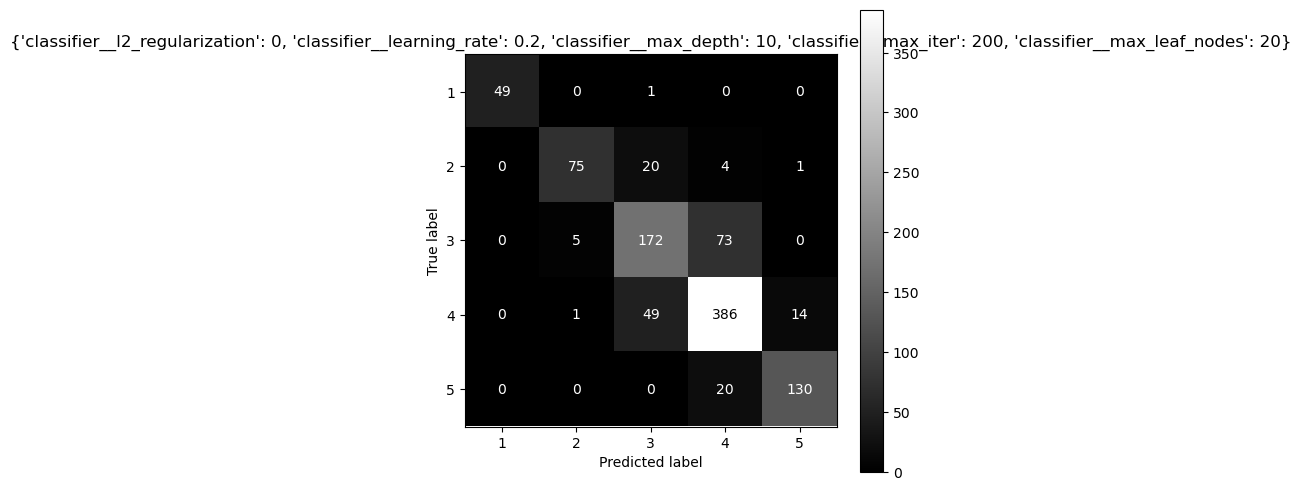

In [16]:
pipeGrid = Pipeline(steps=[
    ('feature_selection', SelectFromModel(
        estimator=RandomForestClassifier(random_state=randomState, n_jobs=1),
        threshold='median')
    ),
    ('classifier', HistGradientBoostingClassifier(random_state=randomState))
])

param_grid = {
    'classifier__learning_rate': [0.1,0.2],
    'classifier__max_iter': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__l2_regularization': [0, 0.01],
    'classifier__max_leaf_nodes': [10,20]
}

gridSearch = GridSearchCV(
    estimator   =pipeGrid,
    param_grid  =param_grid,
    scoring     ='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=3
)

gridSearch.fit(XTrain, yTrain)

for metricName, scorer in scoringMetrix.items():
        scorer = get_scorer(scorer)
        score = scorer(gridSearch, XTest, yTest)
        print(f"{metricName:<12}: {score:.5f}")

yPred = gridSearch.predict(XTest)
confusionMatrix = confusion_matrix(yTest, yPred)
display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=gridSearch.classes_)

fig, axes = plt.subplots(figsize=(6, 6))
display.plot(cmap='gist_gray', ax=axes, values_format='d')
plt.title(f'{gridSearch.best_params_}')
plt.show()